# Creating Network
In this notebokt a simple network is created with all the needed attributes specified for each link (and node).
At the end of this part it should be clear how to:
- set up a simple network of nodes and links
- assign attributes to links and nodes
- rightly connect the centroids to the network
- calculate shortest paths between centroids in the network

## Software

We will use python packages to build grpahs and calculate networks. It is important to keep in mind that having a clear and compact data structure makes it easier to integrate it further to come to a full four-step model, meaning that it is important to automate repetitive process as mucha s possible and create an object comprising all information.

In [141]:
# Import packages
import numpy as np
import networkx as nx
import hvplot.networkx as hvnx
from stapy.network_data import create_cascetta_nw, create_grid_nw
from stapy.visualization import *
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from shapely.geometry import Polygon, box
import pandas as pd
import geopandas as gpd
import geoplot
from math import ceil

In [142]:
g = create_cascetta_nw()
for i in g.nodes:
    g.nodes[i]['xn'] = g.nodes[i].pop('x')
    g.nodes[i]['yn'] = g.nodes[i].pop('y')
p_x = nx.get_node_attributes(g, 'xn')
p_y = nx.get_node_attributes(g, 'yn')
pos = {}
for i in p_x.keys():
    pos[i] = tuple(d[i] for d in [p_x,p_y])
hvnx.draw(g,pos, with_labels=True)

:Overlay
   .Graph.I  :Graph   [start,end]   (capacity,length,maxspeed,travel_time)
   .Labels.I :Labels   [x,y]   (index)

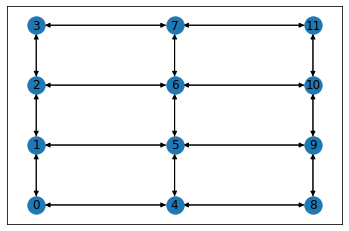

In [143]:
gr = create_grid_nw(4, 3)
nx.draw_networkx(gr, nx.get_node_attributes(gr, 'crd'))

In [144]:
def create_mesh(row, col, height=1, width=1):
    # Box (min x, min y, max x, max y)
    mesh = []
    ymin = -1
    xmin = -1
    # get rows
    rows = ceil((row - ymin) / height)
    # get columns
    cols = ceil((col - xmin) / width)
    # Set initial value
    c = 0
    id = 0
    xl = xmin
    xr = xmin + width
    list_id = []
    while c < cols:
        yb = ymin
        yt = ymin + height
        r = 0
        while r < rows:
            poly = box(xl, yb, xr, yt)
            mesh.append(poly)
            list_id.append(f'c{id}')
            id += 1
            r += 1
            yb += height
            yt += height
        c += 1
        xl += width
        xr += width
    list_centroid = [p.centroid.coords[0] for p in mesh]
    df = pd.DataFrame([list_id, list_centroid]).transpose()
    df.columns = ['id', 'centroid']
    gdf = gpd.GeoDataFrame(df, geometry=mesh)
    return gdf

grid = create_mesh(4, 3, height=2, width=2)

In [145]:
import os
import ogr
from math import ceil

def construct_2d_space(outputGridfn, row: int, col: int, gridHeight=1, gridWidth=1):
    """
    Create a grid of a specified bounding box in cartesian space
    Constructing rectangular grids, more sizes can be included later
    Based on code taken from https://pcjericks.github.io/py-gdalogr-cookbook

    Parameters
    ----------
    outputGridfn:
    row: rows specified in network grid
    col: columns specified in network grid
    gridHeight: height of every grid cell, default = 1
    gridWidth: width of every grid cell, default = 1

    """
    # centroids: int, row: int, col: int)
    min_x, max_x, min_y, max_y = -1, col, -1, row  # boundaries of bounding box limiting 2D space
    # convert sys.argv to float
    xmin = float(min_x)
    xmax = float(max_x)
    ymin = float(min_y)
    ymax = float(max_y)
    gridWidth = float(gridWidth)
    gridHeight = float(gridHeight)

    # get rows
    rows = ceil((ymax - ymin) / gridHeight)
    # get columns
    cols = ceil((xmax - xmin) / gridWidth)

    # start grid cell envelope
    ringXleftOrigin = xmin
    ringXrightOrigin = xmin + gridWidth
    ringYtopOrigin = ymax
    ringYbottomOrigin = ymax - gridHeight

    # create output file
    outDriver = ogr.GetDriverByName('ESRI Shapefile')
    if os.path.exists(outputGridfn):
        os.remove(outputGridfn)
    outDataSource = outDriver.CreateDataSource(outputGridfn)
    outLayer = outDataSource.CreateLayer(outputGridfn, geom_type=ogr.wkbPolygon)
    featureDefn = outLayer.GetLayerDefn()

    # create grid cells
    countcols = 0
    while countcols < cols:
        countcols += 1

        # reset envelope for rows
        ringYtop = ringYtopOrigin
        ringYbottom = ringYbottomOrigin
        countrows = 0

        while countrows < rows:
            countrows += 1
            ring = ogr.Geometry(ogr.wkbLinearRing)
            ring.AddPoint(ringXleftOrigin, ringYtop)
            ring.AddPoint(ringXrightOrigin, ringYtop)
            ring.AddPoint(ringXrightOrigin, ringYbottom)
            ring.AddPoint(ringXleftOrigin, ringYbottom)
            ring.AddPoint(ringXleftOrigin, ringYtop)
            poly = ogr.Geometry(ogr.wkbPolygon)
            poly.AddGeometry(ring)

            # add new geom to layer
            outFeature = ogr.Feature(featureDefn)
            outFeature.SetGeometry(poly)
            outLayer.CreateFeature(outFeature)
            outFeature = None

            # new envelope for next poly
            ringYtop = ringYtop - gridHeight
            ringYbottom = ringYbottom - gridHeight

        # new envelope for next poly
        ringXleftOrigin = ringXleftOrigin + gridWidth
        ringXrightOrigin = ringXrightOrigin + gridWidth

    # Save and close DataSources
    outDataSource = None
    return outLayer



In [205]:
from scipy.spatial import cKDTree
centr_list = [(i[0], {'crd': i[1], 'centroid': True}) for i in grid.values]
gr.add_nodes_from(centr_list)
a = np.array(gr.nodes.data('crd'), dtype=object)
tree = cKDTree(np.array(a[:,1].tolist()))
#dist = np.linalg.norm(np.asarray(gr.nodes.data('crd')[0])-np.asarray(gr.nodes.data('crd')[1]))
tree.query(np.array(a[:,1].tolist()), 1)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7, 15,  9, 10, 11,  0,  2, 14, 15, 10,
        17]))

<AxesSubplot:>

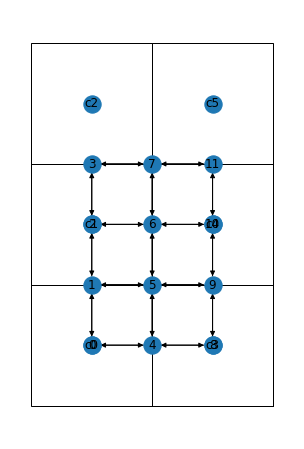

In [201]:
fig, ax = plt.subplots(figsize=(6,8))
nx.draw_networkx(gr, nx.get_node_attributes(gr, 'crd'), ax=ax)
geoplot.polyplot(grid, ax=ax)

In [159]:
np.asarray(gr.nodes.data())

array([[0, {'crd': (0, 0)}],
       [1, {'crd': (0, 1)}],
       [2, {'crd': (0, 2)}],
       [3, {'crd': (0, 3)}],
       [4, {'crd': (1, 0)}],
       [5, {'crd': (1, 1)}],
       [6, {'crd': (1, 2)}],
       [7, {'crd': (1, 3)}],
       [8, {'crd': (2, 0)}],
       [9, {'crd': (2, 1)}],
       [10, {'crd': (2, 2)}],
       [11, {'crd': (2, 3)}],
       ['c0', {'crd': (-0.0, -0.0), 'centroid': True}],
       ['c1', {'crd': (-0.0, 2.0), 'centroid': True}],
       ['c2', {'crd': (-0.0, 4.0), 'centroid': True}],
       ['c3', {'crd': (2.0, -0.0), 'centroid': True}],
       ['c4', {'crd': (2.0, 2.0), 'centroid': True}],
       ['c5', {'crd': (2.0, 4.0), 'centroid': True}]], dtype=object)

In [189]:
np.array(a[:,1].tolist())

array([[ 0.,  0.],
       [ 0.,  1.],
       [ 0.,  2.],
       [ 0.,  3.],
       [ 1.,  0.],
       [ 1.,  1.],
       [ 1.,  2.],
       [ 1.,  3.],
       [ 2.,  0.],
       [ 2.,  1.],
       [ 2.,  2.],
       [ 2.,  3.],
       [-0., -0.],
       [-0.,  2.],
       [-0.,  4.],
       [ 2., -0.],
       [ 2.,  2.],
       [ 2.,  4.]])

In [174]:
np.array(gr.nodes.data('crd'),dtype=object)[:,0]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 'c0', 'c1', 'c2', 'c3', 'c4',
       'c5'], dtype=object)

In [134]:
df = pd.DataFrame(gr.nodes.data())

AttributeError: 'NodeDataView' object has no attribute 'keys'

In [153]:
centr_list = [(i[0], {'crd': i[1], 'centroid': True}) for i in grid.values]

In [154]:
centr_list

[('c0', {'crd': (-0.0, -0.0), 'centroid': True}),
 ('c1', {'crd': (-0.0, 2.0), 'centroid': True}),
 ('c2', {'crd': (-0.0, 4.0), 'centroid': True}),
 ('c3', {'crd': (2.0, -0.0), 'centroid': True}),
 ('c4', {'crd': (2.0, 2.0), 'centroid': True}),
 ('c5', {'crd': (2.0, 4.0), 'centroid': True})]